In [9]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

In [10]:
# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': 'lavender'}, style='darkgrid')

In [11]:
df = pd.read_csv('C:/Users/HP/Desktop/TugasUasKb/hotelbooking/hotel_booking.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [13]:
# Based on the given dataset description, list the columns that are categorical in terms of their semantics
categorical_columns_semantics = [
    'hotel',
    'is_canceled',
    'arrival_date_year',
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'is_repeated_guest',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
    'reservation_status',
    'name',
    'email',
    'phone-number',
    'credit_card'
]

# Convert these columns to string (object) data type
for column in categorical_columns_semantics:
    if column in df.columns:
        df[column] = df[column].astype(str)

# Verify the changes in data types
df.dtypes

hotel                              object
is_canceled                        object
lead_time                           int64
arrival_date_year                  object
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                  object
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [14]:
# Get the summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0
previous_cancellations,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0
previous_bookings_not_canceled,119390.0,0.137097,1.497437,0.00,0.00,0.000,0.0,72.0


In [15]:
# Get the summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
hotel,119390,2,City Hotel,79330
is_canceled,119390,2,0,75166
arrival_date_year,119390,3,2016,56707
arrival_date_month,119390,12,August,13877
meal,119390,5,BB,92310
country,119390,178,PRT,48590
market_segment,119390,8,Online TA,56477
distribution_channel,119390,5,TA/TO,97870
is_repeated_guest,119390,2,0,115580
reserved_room_type,119390,10,A,85994


In [16]:
# Reload the dataset to retain the original data types of the variables
df = pd.read_csv('C:/Users/HP/Desktop/TugasUasKb/hotelbooking/hotel_booking.csv')

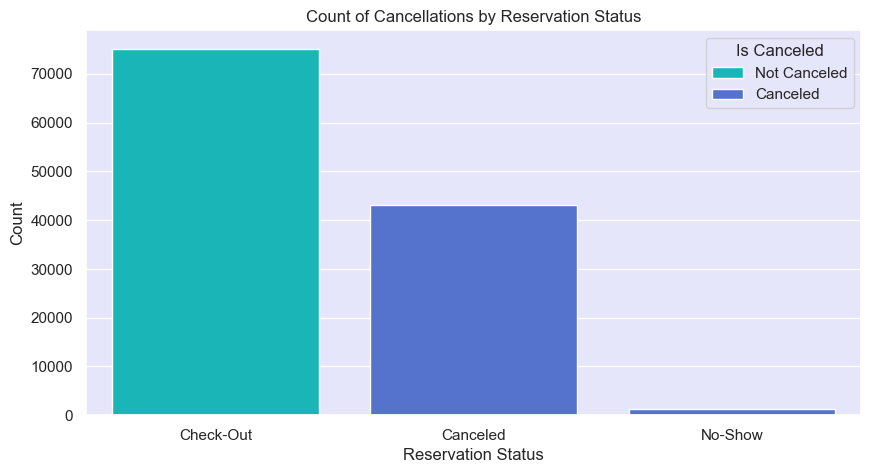

In [17]:
# Bivariate bar plot of 'is_canceled' vs 'reservation_status' with specified colors
plt.figure(figsize=(10, 5))
sns.countplot(x='reservation_status', hue='is_canceled', data=df, palette=['darkturquoise', 'royalblue'])
plt.title('Count of Cancellations by Reservation Status')
plt.xlabel('Reservation Status')
plt.ylabel('Count')
plt.legend(title='Is Canceled', labels=['Not Canceled', 'Canceled'])
plt.show()

In [18]:
df.groupby('reservation_status')['is_canceled'].mean()

reservation_status
Canceled     1.0
Check-Out    0.0
No-Show      1.0
Name: is_canceled, dtype: float64

In [19]:
# Drop the `reservation_status` feature
df = df.drop(['reservation_status'], axis=1)

In [20]:
# Convert 'reservation_status_date' to datetime format
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Extract Days_Difference from 'reservation_status_date'
df['reservation_status_days_difference'] = (df['reservation_status_date'] - pd.to_datetime(df['arrival_date_year'].astype(str) + '-' + df['arrival_date_month'] + '-' + df['arrival_date_day_of_month'].astype(str))).dt.days

df[['reservation_status_days_difference']].head()

,reservation_status_days_difference
0,0
1,0
2,1
3,1
4,2


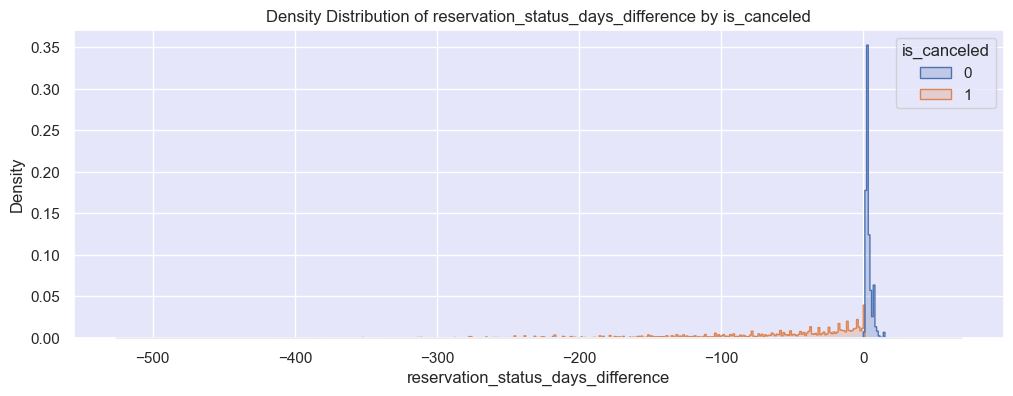

In [21]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df, x="reservation_status_days_difference", hue="is_canceled", element="step", stat="density", common_norm=False)
plt.title('Density Distribution of reservation_status_days_difference by is_canceled')
plt.show()

In [22]:
# For positive values of reservation_status_days_difference
print("Distribution of 'is_canceled' when 'reservation_status_days_difference' is positive:\n")
print(df[df['reservation_status_days_difference'] > 0]['is_canceled'].value_counts())

# For negative values of reservation_status_days_difference
print("\n" + "-"*85)
print("\nDistribution of 'is_canceled' when 'reservation_status_days_difference' is negative:\n")
print(df[df['reservation_status_days_difference'] < 0]['is_canceled'].value_counts())

Distribution of 'is_canceled' when 'reservation_status_days_difference' is positive:

is_canceled
0    74460
Name: count, dtype: int64

-------------------------------------------------------------------------------------

Distribution of 'is_canceled' when 'reservation_status_days_difference' is negative:

is_canceled
1    42137
Name: count, dtype: int64


In [23]:
# Drop the 'reservation_status_date' and 'reservation_status_days_difference' columns
df = df.drop(['reservation_status_date', 'reservation_status_days_difference'], axis=1)

In [24]:
df = df.drop(['assigned_room_type'], axis=1)

In [25]:
df['arrival_date_year'].value_counts()

arrival_date_year
2016    56707
2017    40687
2015    21996
Name: count, dtype: int64

In [26]:
# Drop the `arrival_date_year` feature
df = df.drop(['arrival_date_year'], axis=1)

In [27]:
# Create a dataframe with the number of unique categories and missing values for each high-cardinality feature
high_cardinality_features = ['country', 'agent', 'company', 'name', 'email', 'phone-number', 'credit_card']
unique_categories = df[high_cardinality_features].nunique()
missing_values = df[high_cardinality_features].isnull().sum()

# Combine the two series into a single dataframe
high_cardinality_df = pd.DataFrame({'Unique_Categories': unique_categories, 'Missing_Values': missing_values})

high_cardinality_df

,Unique_Categories,Missing_Values
country,177,488
agent,333,16340
company,352,112593
name,81503,0
email,115889,0
phone-number,119390,0
credit_card,9000,0


In [28]:
# Feature Engineering for 'name' feature
# Create a new feature representing the number of bookings made by each guest (based on the name)
df['number_of_bookings'] = df.groupby('name')['name'].transform('count')

# Drop the original 'name' feature and other high-cardinality features
df = df.drop(['name', 'country', 'agent', 'company', 'email', 'phone-number', 'credit_card'], axis=1)

df[['number_of_bookings']].head()

,number_of_bookings
0,1
1,2
2,3
3,1
4,1


In [29]:
# Calculate the missing values percentage in the original dataset
missing_values_percentage = (df.isnull().sum() / len(df)) * 100
missing_values_percentage[missing_values_percentage > 0]

children    0.00335
dtype: float64

In [30]:
df['children'].value_counts()

children
0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: count, dtype: int64

In [31]:
# Impute missing values in 'children' column with 0
df['children'] = df['children'].fillna(0)

# Check if there are any missing values left in 'children' column
df['children'].isnull().sum()

np.int64(0)

In [32]:
# Analyze noisy data
noisy_data = {
    'adr':      df[df['adr'] < 0],
    'adults':   df[df['adults'] == 0],
    'children': df[df['children'] == 10],
    'babies':   df[df['babies'] == 10],
}

noisy_data_count = {key: len(value) for key, value in noisy_data.items()}
noisy_data_count

{'adr': 1, 'adults': 403, 'children': 1, 'babies': 1}

In [33]:
# Replace negative adr with median of adr column
df.loc[df['adr'] < 0, 'adr'] = df['adr'].median()

# Remove rows with 0 adults
df = df[df['adults'] != 0]

# Remove rows with 10 children or 10 babies
df = df[df['children'] != 10]
df = df[df['babies'] != 10]

# Reset the index
df.reset_index(drop=True, inplace=True)

# Check if the noisy data has been handled
noisy_data_handled = {
    'adr': df[df['adr'] < 0],
    'adults': df[df['adults'] == 0],
    'children': df[df['children'] == 10],
    'babies': df[df['babies'] == 10],
}

noisy_data_handled_count = {key: len(value) for key, value in noisy_data_handled.items()}
noisy_data_handled_count

{'adr': 0, 'adults': 0, 'children': 0, 'babies': 0}

In [34]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list                int64
customer_type                      object
adr                               float64
required_car_parking_spaces       

In [35]:
# Convert 'arrival_date_month' to numerical values
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['arrival_date_month'] = df['arrival_date_month'].apply(lambda x: months.index(x) + 1)

# One-hot encode the specified columns
one_hot_cols = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118985 entries, 0 to 118984
Data columns (total 48 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118985 non-null  int64  
 1   lead_time                       118985 non-null  int64  
 2   arrival_date_month              118985 non-null  int64  
 3   arrival_date_week_number        118985 non-null  int64  
 4   arrival_date_day_of_month       118985 non-null  int64  
 5   stays_in_weekend_nights         118985 non-null  int64  
 6   stays_in_week_nights            118985 non-null  int64  
 7   adults                          118985 non-null  int64  
 8   children                        118985 non-null  float64
 9   babies                          118985 non-null  int64  
 10  is_repeated_guest               118985 non-null  int64  
 11  previous_cancellations          118985 non-null  int64  
 12  previous_booking

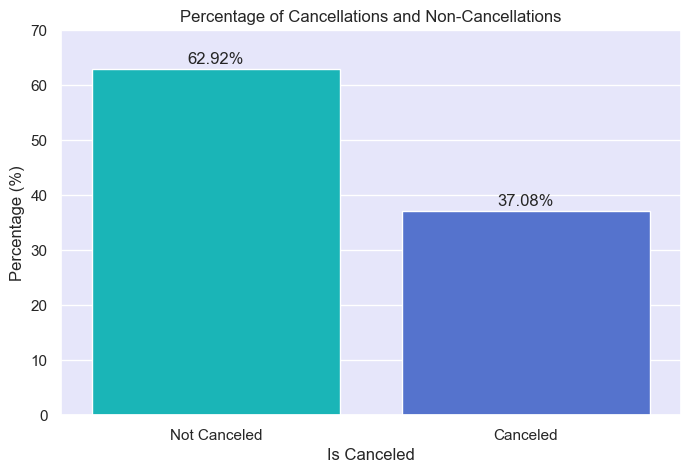

In [36]:
# Calculating the percentage of each class
percentage = df['is_canceled'].value_counts(normalize=True) * 100

# Plotting the percentage of each class
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=percentage.index, y=percentage, palette=['darkturquoise', 'royalblue'])
plt.title('Percentage of Cancellations and Non-Cancellations')
plt.xlabel('Is Canceled')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.yticks(ticks=range(0,80,10))

# Displaying the percentage on the bars
for i, p in enumerate(percentage):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118985 entries, 0 to 118984
Data columns (total 48 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118985 non-null  int64  
 1   lead_time                       118985 non-null  int64  
 2   arrival_date_month              118985 non-null  int64  
 3   arrival_date_week_number        118985 non-null  int64  
 4   arrival_date_day_of_month       118985 non-null  int64  
 5   stays_in_weekend_nights         118985 non-null  int64  
 6   stays_in_week_nights            118985 non-null  int64  
 7   adults                          118985 non-null  int64  
 8   children                        118985 non-null  float64
 9   babies                          118985 non-null  int64  
 10  is_repeated_guest               118985 non-null  int64  
 11  previous_cancellations          118985 non-null  int64  
 12  previous_booking

In [38]:
# Define the features (X) and the output labels (y)
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

In [39]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [40]:
# Define the base DT model
dt_base = DecisionTreeClassifier(random_state=0)

In [41]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='f1', n_splits=5):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest F1-score for class 1 (canceled bookings) is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [42]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [13, 14, 15],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}

In [43]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [44]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'class_weight': {0: 1, 1: 2}, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [45]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    The metrics are calculated specifically for class 1.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, pos_label=1),
                                recall_score(y_test, y_pred, pos_label=1),
                                f1_score(y_test, y_pred, pos_label=1),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])],
                          index=['Accuracy','Precision (Class 1)','Recall (Class 1)','F1-score (Class 1)','AUC (Class 1)'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [46]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Define a colormap
    royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    royalblue_r = royalblue.reversed()

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show()


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     59897
           1       0.74      0.85      0.79     35291

    accuracy                           0.83     95188
   macro avg       0.82      0.84      0.83     95188
weighted avg       0.84      0.83      0.84     95188


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.80      0.84     14974
           1       0.70      0.81      0.75      8823

    accuracy                           0.80     23797
   macro avg       0.79      0.80      0.79     23797
weighted avg       0.81      0.80      0.81     23797



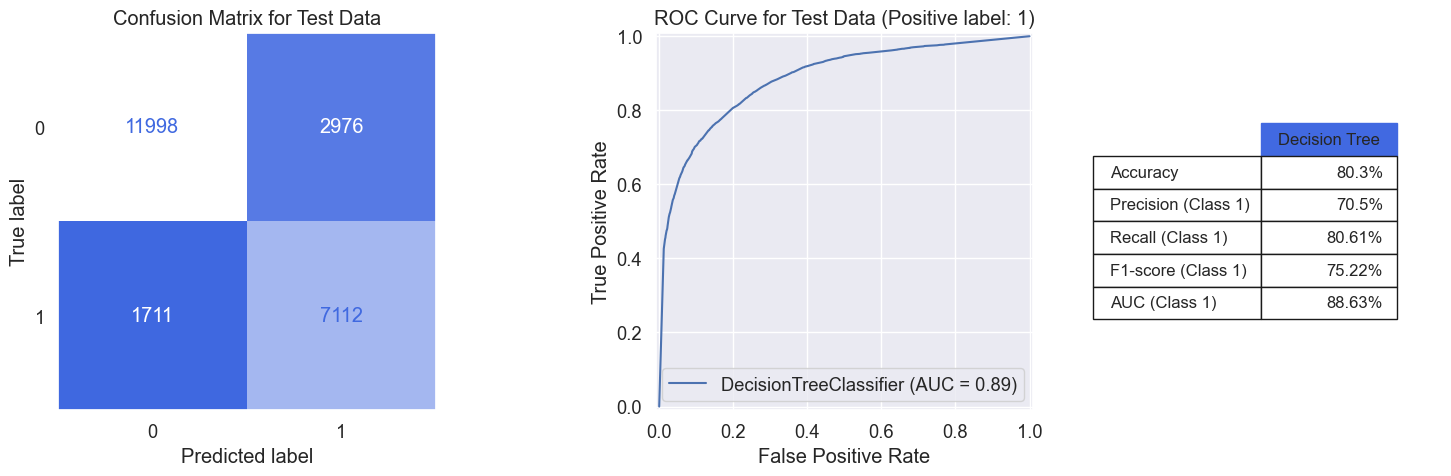

In [47]:
model_evaluation(best_dt, X_train, X_test, y_train, y_test, 'Decision Tree')

In [48]:
# Save the final performance of DT classifier
dt_result = metrics_calculator(best_dt, X_test, y_test, 'Decision Tree')
dt_result

,Decision Tree
Accuracy,80.3%
Precision (Class 1),70.5%
Recall (Class 1),80.61%
F1-score (Class 1),75.22%
AUC (Class 1),88.63%
